In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import matplotlib.patches as patches
import os
import torch
import torchvision

In [11]:
def extract_bbox(image, x1, y1, x2, y2, width, height):
    # Calculate the size of the side of the square bounding box
    side = max(x2 - x1, y2 - y1)

    # Initialize the center coordinates
    center_x = 0
    center_y = 0

    if side == x2 - x1:
        center_x = x1
        # Calculate the vertical center, convert to integer
        center_y = int(y1 + (y2 - y1) / 2 - side / 2)
    elif side == y2 - y1:
        # Calculate the horizontal center, convert to integer
        center_x = int(x1 + (x2 - x1) / 2 - side / 2)
        center_y = y1

    # Adjust to keep within bounds
    # Ensure the crop box does not go beyond the image boundaries
    start_y = max(0, center_y)
    end_y = min(height, center_y + side)
    start_x = max(0, center_x)
    end_x = min(width, center_x + side)

    # Adjust dimensions if the box is out of bounds (especially on the lower edges)
    if end_y - start_y < side:
        start_y = max(0, end_y - side)  # Shift up if bottom edge is out
    if end_x - start_x < side:
        start_x = max(0, end_x - side)  # Shift left if right edge is out

    # Return the cropped image
    return image[start_y:end_y, start_x:end_x]


In [12]:
train_dir = './dataset/train'
ctrain_dir = './data_classifier/train'

test_dir = './dataset/test'
ctest_dir = './data_classifier/test'

valid_dir = './dataset/valid'
cvalid_dir = './data_classifier/valid'

def create_folder(newpath):
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
create_folder(ctrain_dir)
create_folder(ctest_dir)
create_folder(cvalid_dir)

In [13]:
import pandas as pd
import csv

def convert_class_to_index(class_char):
    return ord(class_char.upper()) - ord('A')

def reformat_csv(input_file_path, output_file_path):
    with open(input_file_path, mode='r', newline='') as infile, \
         open(output_file_path, mode='w', newline='') as outfile:
        reader = csv.DictReader(infile)
        writer = csv.writer(outfile)
        writer.writerow(['filename', 'class'])

        for row in reader:
            filename = row['filename']
            class_index = convert_class_to_index(row['class'])
            writer.writerow([filename, class_index])


def create_dataset(csv_file, image_dir, output_dir):
    output_csv_file = os.path.join(output_dir, os.path.basename(csv_file))
    reformat_csv(csv_file, output_csv_file)
    
    df = pd.read_csv(csv_file)
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['filename'])
        img = cv2.imread(img_path)
        if img is not None:
            img_cropped = extract_bbox(img, row['xmin'], row['ymin'], row['xmax'], row['ymax'], row['width'], row['height'])
            output_path = os.path.join(output_dir, row['filename'])
            cv2.imwrite(output_path, img_cropped)
            print(img_path + " file moved to: " + output_path)


create_dataset(os.path.join(train_dir, '_annotations.csv'), train_dir, ctrain_dir)
create_dataset(os.path.join(test_dir, '_annotations.csv'), test_dir, ctest_dir)
create_dataset(os.path.join(valid_dir, '_annotations.csv'), valid_dir, cvalid_dir)


./dataset/train\U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg file moved to: ./data_classifier/train\U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg
./dataset/train\P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg file moved to: ./data_classifier/train\P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg
./dataset/train\K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg file moved to: ./data_classifier/train\K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg
./dataset/train\W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg file moved to: ./data_classifier/train\W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg
./dataset/train\J30_jpg.rf.00d20e595026b31773ded47509545471.jpg file moved to: ./data_classifier/train\J30_jpg.rf.00d20e595026b31773ded47509545471.jpg
./dataset/train\M27_jpg.rf.010d328cdc61a634aec1540863be23b9.jpg file moved to: ./data_classifier/train\M27_jpg.rf.010d328cdc61a634aec1540863be23b9.jpg
./dataset/train\N23_jpg.rf.01428a442131e7dcbdb4453df83877e0.jpg file moved to: ./data_classifier/tra

In [14]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.data_frame.iloc[idx, 1] 

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [32]:
trainset = CustomDataset(os.path.join(ctrain_dir, '_annotations.csv'), ctrain_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

testset = CustomDataset(os.path.join(ctest_dir, '_annotations.csv'), ctest_dir, transform=transform)
testloader = DataLoader(trainset, batch_size=4, shuffle=False)

validset = CustomDataset(os.path.join(cvalid_dir, '_annotations.csv'), cvalid_dir, transform=transform)
validloader = DataLoader(validset, batch_size=4, shuffle=False)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN Class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
print(Net())

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)


In [17]:
import torch.optim as optim

net=Net()
CUDA=torch.cuda.is_available()
if CUDA:
    net=net.cuda()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
accuracy_values=[]
epoch_number=[]
for epoch in range(50):  # loop over the dataset multiple times. Here 10 means 10 epochs
    running_loss = 0.0
    for i, (inputs,labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if CUDA:
          inputs = inputs.cuda()
          labels = labels.cuda()
        else:
          inputs = inputs.cpu()
          labels = labels.cpu()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 200 mini-batches
            print('[epoch%d, itr%5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 49))
            running_loss = 0.0

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            if CUDA:
              images = images.cuda()
              labels = labels.cuda()
            else:
              images = images.cpu()
              labels =labels.cpu()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if CUDA:
              correct += (predicted.cpu()==labels.cpu()).sum().item()
            else:
              correct += (predicted==labels).sum().item()

        TestAccuracy = 100 * correct / total
        epoch_number += [epoch+1]
        accuracy_values += [TestAccuracy]
        print('Epoch=%d Test Accuracy=%.3f' %
                  (epoch + 1, TestAccuracy))

print('Finished Training')

[epoch1, itr   50] loss: 3.324
[epoch1, itr  100] loss: 3.319
[epoch1, itr  150] loss: 3.325
[epoch1, itr  200] loss: 3.329
[epoch1, itr  250] loss: 3.323
[epoch1, itr  300] loss: 3.329
[epoch1, itr  350] loss: 3.319
Epoch=1 Test Accuracy=3.968
[epoch2, itr   50] loss: 3.314
[epoch2, itr  100] loss: 3.321
[epoch2, itr  150] loss: 3.322
[epoch2, itr  200] loss: 3.318
[epoch2, itr  250] loss: 3.313
[epoch2, itr  300] loss: 3.322
[epoch2, itr  350] loss: 3.326
Epoch=2 Test Accuracy=5.159
[epoch3, itr   50] loss: 3.321
[epoch3, itr  100] loss: 3.313
[epoch3, itr  150] loss: 3.316
[epoch3, itr  200] loss: 3.314
[epoch3, itr  250] loss: 3.320
[epoch3, itr  300] loss: 3.310
[epoch3, itr  350] loss: 3.322
Epoch=3 Test Accuracy=5.754
[epoch4, itr   50] loss: 3.313
[epoch4, itr  100] loss: 3.304
[epoch4, itr  150] loss: 3.309
[epoch4, itr  200] loss: 3.323
[epoch4, itr  250] loss: 3.312
[epoch4, itr  300] loss: 3.313
[epoch4, itr  350] loss: 3.317
Epoch=4 Test Accuracy=5.423
[epoch5, itr   50] l

[3.9682539682539684, 5.158730158730159, 5.753968253968254, 5.423280423280423, 5.48941798941799, 5.026455026455026, 6.150793650793651, 7.407407407407407, 12.632275132275133, 13.69047619047619, 19.70899470899471, 25.727513227513228, 26.85185185185185, 39.74867724867725, 46.89153439153439, 55.75396825396825, 61.30952380952381, 68.51851851851852, 67.85714285714286, 80.62169312169313, 84.52380952380952, 85.05291005291005, 92.46031746031746, 88.75661375661376, 94.04761904761905, 94.84126984126983, 94.84126984126983, 93.91534391534391, 97.88359788359789, 99.73544973544973, 99.93386243386243, 99.4047619047619, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


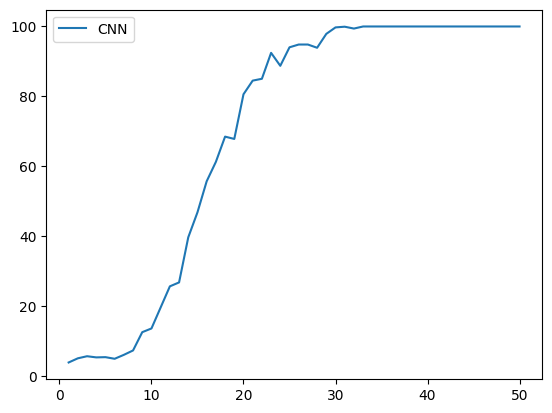

In [19]:
import matplotlib.pyplot as plt
import numpy as np

print(accuracy_values)
# Plot the data
plt.plot(epoch_number, accuracy_values, label='CNN')

# Add a legend
plt.legend()

# Show the plot
plt.show()

torch.Size([4, 3, 32, 32])


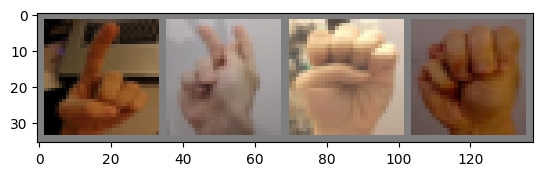

    D     K     E     M


In [24]:
import matplotlib.pyplot as plt
import numpy as np

classes = tuple(chr(i) for i in range(65, 91))

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.size())
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

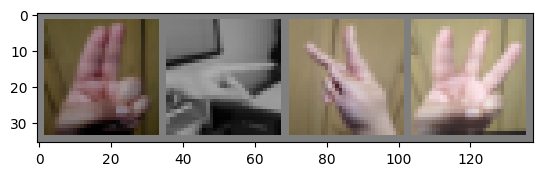

GroundTruth:      U     P     K     W
Predicted:      U     P     K     W


In [25]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

if CUDA:
  images = images.cuda()
  labels = labels.cuda()
else:
  images = images.cpu()
  labels =labels.cpu()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [22]:
class_correct = list(0. for i in range(26))
class_total = list(0. for i in range(26))
with torch.no_grad():
    for images, labels in testloader:
        if CUDA:
          images =images.cuda()
          labels =labels.cuda()
        else:
          images =images.cpu()
          labels =labels.cpu()

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(26):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     A : 100 %
Accuracy of     B : 100 %
Accuracy of     C : 100 %
Accuracy of     D : 100 %
Accuracy of     E : 100 %
Accuracy of     F : 100 %
Accuracy of     G : 100 %
Accuracy of     H : 100 %
Accuracy of     I : 100 %
Accuracy of     J : 100 %
Accuracy of     K : 100 %
Accuracy of     L : 100 %
Accuracy of     M : 100 %
Accuracy of     N : 100 %
Accuracy of     O : 100 %
Accuracy of     P : 100 %
Accuracy of     Q : 100 %
Accuracy of     R : 100 %
Accuracy of     S : 100 %
Accuracy of     T : 100 %
Accuracy of     U : 100 %
Accuracy of     V : 100 %
Accuracy of     W : 100 %
Accuracy of     X : 100 %
Accuracy of     Y : 100 %
Accuracy of     Z : 100 %


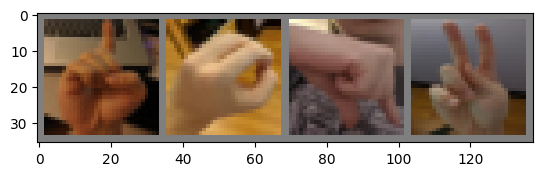

GroundTruth:      D     O     Q     K
Predicted:      I     N     Q     B


In [33]:
# validate with validloader
dataiter = iter(validloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

if CUDA:
  images = images.cuda()
  labels = labels.cuda()
else:
  images = images.cpu()
  labels =labels.cpu()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [34]:
class_correct = list(0. for i in range(26))
class_total = list(0. for i in range(26))
with torch.no_grad():
    for images, labels in validloader:
        if CUDA:
          images =images.cuda()
          labels =labels.cuda()
        else:
          images =images.cpu()
          labels =labels.cpu()

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(26):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     A : 60 %
Accuracy of     B : 44 %
Accuracy of     C : 66 %
Accuracy of     D : 16 %
Accuracy of     E : 50 %
Accuracy of     F : 25 %
Accuracy of     G : 40 %
Accuracy of     H : 55 %
Accuracy of     I :  0 %
Accuracy of     J : 75 %
Accuracy of     K : 16 %
Accuracy of     L : 75 %
Accuracy of     M : 12 %
Accuracy of     N : 25 %
Accuracy of     O : 28 %
Accuracy of     P : 42 %
Accuracy of     Q : 50 %
Accuracy of     R : 14 %
Accuracy of     S : 75 %
Accuracy of     T : 33 %
Accuracy of     U : 71 %
Accuracy of     V : 20 %
Accuracy of     W : 66 %
Accuracy of     X : 100 %
Accuracy of     Y : 62 %
Accuracy of     Z : 75 %


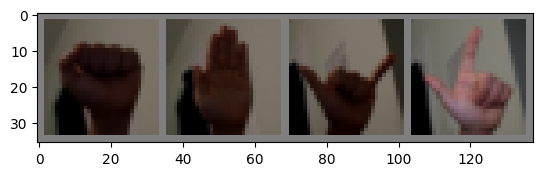

tensor([[ 20.0697,   0.9286,   8.2350, -22.4094,  18.9182,  -6.1933,  -3.2805,
         -11.6791,   1.0379,  15.8375,   2.2514, -15.7906,   7.9431,  -6.2494,
           5.4733, -16.7172,   2.6732,  -3.6829,  16.9069,  21.5817,   0.7859,
          -1.6755, -16.5700, -15.0836, -10.4488,  11.7379],
        [ -9.4773,  12.8751,   5.7692,   3.8537,  -0.7591,  16.5039, -10.6201,
          -6.4881,  -3.4166,  -4.6554,  16.1017, -10.9455,  -4.1815,   1.0103,
           7.1068,  -9.7450, -14.2322,  -1.6507,  15.7403,   1.2874,   5.2514,
           4.9817,  12.1743,  -5.4934,  -8.9580, -15.3092],
        [ -0.5711, -13.8316, -11.4483,  18.3241, -10.2882,  11.7968,  -7.2507,
          -8.9439,  33.1170,   4.7423,  -8.3871, -22.7384,   3.6378,  -8.6927,
          -9.7771,  15.3628,   7.8036,  -1.6009,   0.2542,  -6.7509, -13.4943,
          -0.3555,   0.8139,  -8.8534,  20.1932,  -2.8306],
        [ -6.5133,  -1.3764,  -3.4076,   5.2909,  -5.1186,   8.8997,   3.6874,
          -9.0739,  -4.5291,  

In [30]:
# now, to test the CNN model on newly captured images 

class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB') 

        if self.transform:
            image = self.transform(image)

        return image
    
captureset = UnlabeledImageDataset(image_dir='./data_classifier/captures', transform=transform)
captureloader = DataLoader(captureset, batch_size=4, shuffle=False)

dataiter = iter(captureloader)
images = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images))

# Check if CUDA is available for using GPU
if CUDA:
    images = images.cuda()
else:
    images = images.cpu()

# Get predictions from your network
outputs = net(images)
print(outputs)
_, predicted = torch.max(outputs, 1)

# Print predicted classes
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))